# **🧙‍♂️ Wizard 🪄**
### Finding the optimized bidding strategy for the card game *Wizard* using a genetic algorithm
##### [Here](https://en.wikipedia.org/wiki/Wizard_\(card_game\)#Gameplay) are the rules.
---

## 🧬 Part 1, Genetic Algorithm

This project uses a [genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) to evolve a bidding strategy in the game of Wizard. Each player’s bidding behavior is controlled by a genome — a set of numeric weights influencing how it evaluates its hand.

The GA works as follows:

- **Initialization**: A population of random genomes is created.
- **Evaluation**: Each genome plays in simulated games and is scored based on bidding accuracy.
- **Selection**: The top-performing genomes (elites) are retained.
- **Crossover and Mutation**: New genomes are created by mixing elite genomes and applying random perturbations.
- **Repeat**: The cycle continues for many generations, gradually improving performance.

The goal is to discover a genome that maximizes accurate bidding.


There are many variables that go into the bidding round, I've defined some important heuristics to start:
- High Card Weight
- Wizard Weight
- Jester Weight
- Trump Weight
- Position Bias
- Risk Bias
- Overbid Penalty Weight


---

### Evolution Summary
This section reports the top-performing genome and how fitness evolved across generations.
- **Generations:** 75  
- **Population size:** 30 bots  
- **Elite count:** Top 10 preserved each generation  
- **Games per bot per generation:** 200  
- **Total evolved games:** ≈ 450,000  
- **Selection criteria:** Bots evaluated by total score over games with randomized player count and 2 fixed baselines

---


#### Imports for rest of notebook:

In [39]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display
import random
import seaborn as sns
sys.path.append("pyFiles")
from genetic import evolve, validate_best_genome
from simulation import prob_win
from deck import Card, Deck
from simulation import prob_win
from player import Player, EvolvedPlayer, ProbabilityPlayer
from player import compare_players, validate_probability_player

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Run the genetic algorithm:

In [30]:
df_history, best_genome_data, df_genomes = evolve()
print("\n Evolution Complete")


 Evolution Complete


In [22]:
print(best_genome_data)

{'high_card_weight': 0.859231465682749, 'wizard_weight': 0.7298733217567067, 'jester_weight': -2.0, 'trump_weight': 1.2511813199393091, 'position_bias': -0.28066298709122034, 'risk_bias': -1.1117759617942113, 'overbid_penalty_weight': 1.3519663212358077}


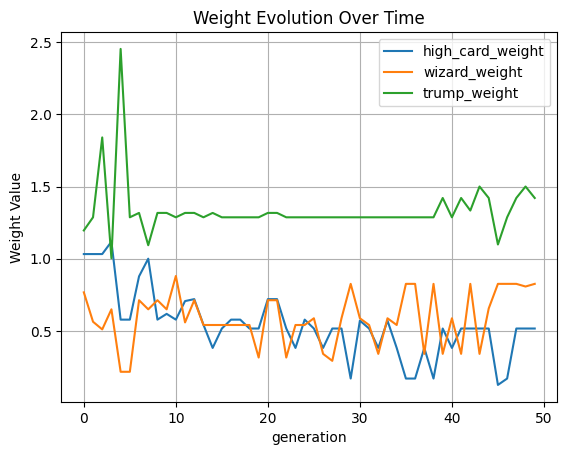

In [31]:
import seaborn as sns

# Suppose you collect genomes each gen in a DataFrame `df_genomes`
sns.lineplot(data=df_genomes, x='generation', y='high_card_weight', label='high_card_weight')
sns.lineplot(data=df_genomes, x='generation', y='wizard_weight', label='wizard_weight')
sns.lineplot(data=df_genomes, x='generation', y='trump_weight', label='trump_weight')
plt.title("Weight Evolution Over Time")
plt.ylabel("Weight Value")
plt.grid(True)
plt.legend()
plt.show()

This chart shows the evolution of bidding accuracy over time. The gap between average and best scores represents selection pressure. A narrowing gap indicates convergence.

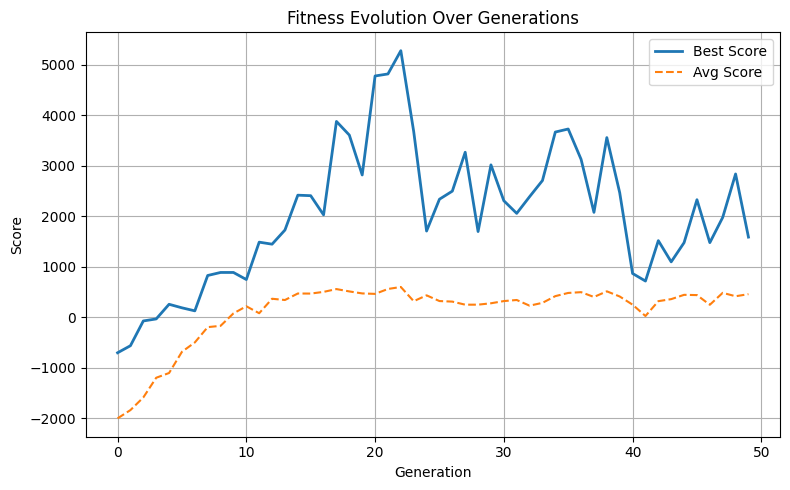

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(df_history['generation'], df_history['best_score'], label='Best Score', linewidth=2)
plt.plot(df_history['generation'], df_history['avg_score'], label='Avg Score', linestyle='--')
plt.xlabel("Generation")
plt.ylabel("Score")
plt.title("Fitness Evolution Over Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
print("\n Best Genome Weights:")
best_genome_series = pd.Series(best_genome_data).round(3).sort_values(key=abs, ascending=False)
print(best_genome_series)


 Best Genome Weights:
jester_weight            -1.480
trump_weight              1.287
overbid_penalty_weight    0.706
risk_bias                -0.535
high_card_weight          0.516
wizard_weight             0.315
position_bias             0.081
dtype: float64


#### ‼️ Interpreting this data & applying it
| Heuristic | Interpretation |
| ------------------------ | ---------- |
| `trump_weight`           | Trump cards are highly valuable. You should heavily favor bidding **higher** when holding strong trump cards.                  |
| `position_bias`          | If you bid earlier in the turn order, be more conservative. Later players have more information and can bid more aggressively. |
| `wizard_weight`          | Wizards strongly increase your bidding potential. Each one should almost always be worth one trick.                            |
| `high_card_weight`       | High non-trump cards help, but much less than trump or wizards. They're not always reliable for taking tricks.                 |
| `risk_bias`              | A slightly conservative tilt overall — only bid aggressively when you're confident.                                            |
| `jester_weight`          | Jesters have a very mild negative effect. They rarely help win tricks, but don’t drastically hurt your chances either.         |
| `overbid_penalty_weight` | This bot doesn’t fear overbidding much. It slightly favors **aiming for a fair bid** over playing it too safe.                 |


---


### Testing our strategy:

In [46]:
validation_df, bid_freq = validate_best_genome(best_genome_data, games=10000, num_players=random.randint(3, 7))


 Validation Results:
   Metric  Value
Avg Score  12.04
Hit Bid % 47.71%
    Games  10000

Bid Distribution (out of 10000 rounds):
   Count Percent
0   4454  44.54%
1   2563  25.63%
2   1852  18.52%
3    930    9.3%
4    176   1.76%
5     24   0.24%
6      1   0.01%


<Axes: title={'center': 'Bid Distribution'}, xlabel='Bid', ylabel='Frequency'>

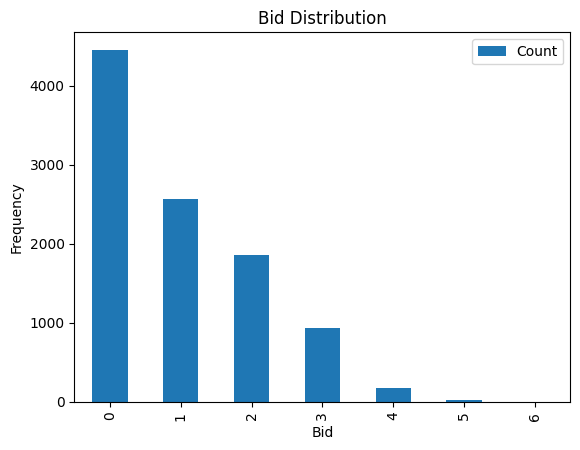

In [47]:
print("\n Validation Results:")
print(validation_df.to_string(index=False))

print("\nBid Distribution (out of 10000 rounds):")
print(bid_freq.to_string())

bid_freq.plot(kind="bar", title="Bid Distribution", xlabel="Bid", ylabel="Frequency")


---
## 🧮 Part 2: Hand Strength Evaluation
### ❓ How can we make this even more accurate?
- We can estimate the probability of each card winning a trick

For small hands (<= 2 cards) we calculate the probabilities, but for larger hands, we run monte carlo-style simulations with random tricks to estimate a probability
For example:

In [36]:
hand = [
    Card("Hearts", "Q"),
    Card("Spades", "9"),
    Card("Clubs", "A")
]

trump_suit = "Spades"
num_players = 4
round_number = len(hand)

# Print win probabilities for each card in hand
print(f"Trump Suit: {trump_suit}, Players: {num_players}, Round: {round_number}")
for card in hand:
    p_win = prob_win(card, hand, trump_suit, num_players, round_number)
    print(f"{card}: Estimated win probability = {p_win:.2%}")


Trump Suit: Spades, Players: 4, Round: 3
Q♥️: Estimated win probability = 31.20%
9♠️: Estimated win probability = 60.20%
A♣️: Estimated win probability = 38.10%


In [37]:
hand = [
    Card("Hearts", "Q"),
    Card("Spades", "9"),
    Card("Clubs", "A"),
    Card("Diamonds", "K"),
    Card("Hearts", "2"),
    Card("Spades", "5"),
    Card("Clubs", "3"),
]

trump_suit = "Spades"
num_players = 5
round_number = len(hand)

print(f"Trump Suit: {trump_suit}, Players: {num_players}, Round: {round_number}")
for card in hand:
    p_win = prob_win(card, hand, trump_suit, num_players, round_number)
    print(f"{card}: Estimated win probability = {p_win:.2%}")

Trump Suit: Spades, Players: 5, Round: 7
Q♥️: Estimated win probability = 20.20%
9♠️: Estimated win probability = 50.40%
A♣️: Estimated win probability = 25.60%
K♦️: Estimated win probability = 23.10%
2♥️: Estimated win probability = 7.60%
5♠️: Estimated win probability = 36.40%
3♣️: Estimated win probability = 8.40%


### Visualization across ranks:

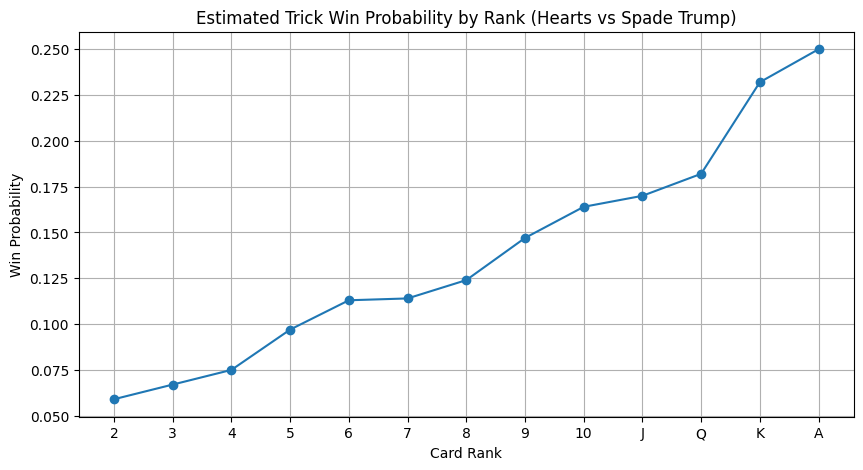

In [40]:
suit = "Hearts"
hand = [Card(suit, rank) for rank in Deck.ranks if rank not in ('W', 'E')]

probs = [
    prob_win(card, hand, trump_suit="Spades", num_players=5, round_number=5)
    for card in hand
]

plt.figure(figsize=(10, 5))
plt.plot(Deck.ranks[:-2], probs, marker='o')
plt.title("Estimated Trick Win Probability by Rank (Hearts vs Spade Trump)")
plt.xlabel("Card Rank")
plt.ylabel("Win Probability")
plt.grid(True)
plt.show()

#### Now to create a bidding strategy, we can sum the probabilities of each card in our hand:

In [49]:
summary, bid_distribution = validate_probability_player(games=100, num_players=5)


 Validation Results:
   Metric  Value
Avg Score  15.37
Hit Bid % 49.00%
    Games    100

Bid Distribution (out of 100 rounds):
   Count Percent
0     11   11.0%
1     27   27.0%
2     32   32.0%
3     15   15.0%
4      4    4.0%
5      4    4.0%
6      3    3.0%
7      4    4.0%


<Axes: title={'center': 'Bid Distribution'}, xlabel='Bid', ylabel='Frequency'>

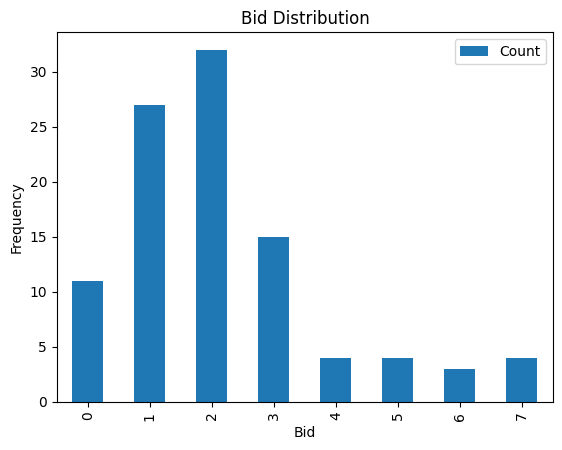

In [50]:
print("\n Validation Results:")
print(summary.to_string(index=False))

print("\nBid Distribution (out of 100 rounds):")
print(bid_distribution.to_string())

bid_distribution.plot(kind="bar", title="Bid Distribution", xlabel="Bid", ylabel="Frequency")

### Now let's compare the Genetic Algorithm to our Probability Algorithm:

In [51]:
summary, bids = compare_players(best_genome_data, games=1000, num_players=5)

print(summary)

       Bot  Avg Score  Hit Bid %
0  Evolved      -0.87       42.2
1     Prob       0.11       38.7


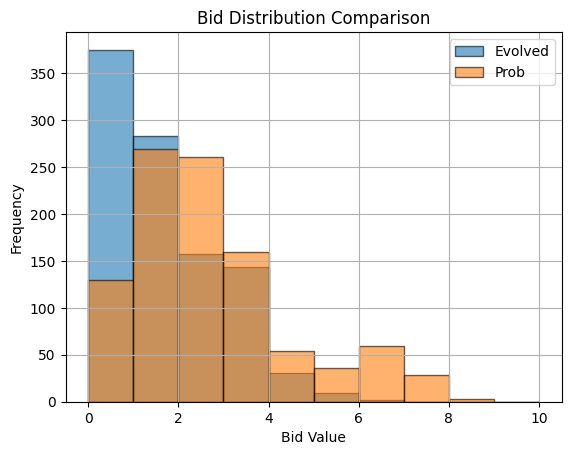

In [52]:
bids.plot.hist(alpha=0.6, bins=range(0, 11), edgecolor='black')
plt.title("Bid Distribution Comparison")
plt.xlabel("Bid Value")
plt.ylabel("Frequency")
plt.legend(bids.columns)
plt.grid(True)
plt.show()

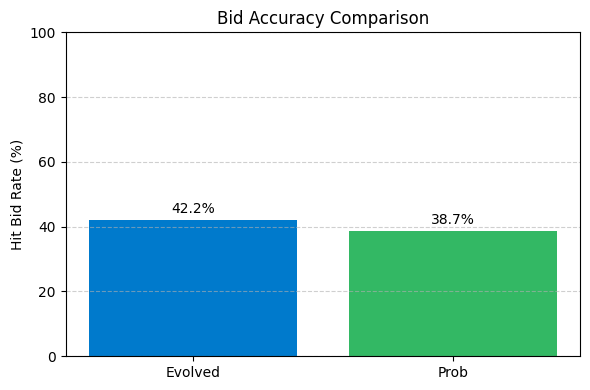

In [53]:
plt.figure(figsize=(6, 4))
bars = plt.bar(summary['Bot'], summary['Hit Bid %'], color=["#007acc", "#33b864"])
plt.title("Bid Accuracy Comparison")
plt.ylabel("Hit Bid Rate (%)")
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval:.1f}%", ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()